# **AIRR-C Meeting Software Demo: ClusTCR**

![](./workflow.png "ClusTCR workflow")

## 1. Installation
ClusTCR runs as a python package, and is available through the conda repository. Therefore, users should have installed anaconda to use make use of the ClusTCR. After installing anaconda, ClusTCR can be installed by running the following command in the command prompt: 
\
\
`$ conda install clustcr -c svalkiers -c bioconda -c pytorch -c conda-forge`

## 1. Importing data
For the purpose of this software demonstration, we will use an example repertoire consisting of **100,000 unique TCR clonotypes** (V + J + CDR3). In addition to `clustcr` We will use the `pandas` library to handle the data.

In [1]:
import pandas as pd # We will use the pandas library for data handling

In [83]:
data = pd.read_csv("./data/repertoire.tsv", sep="\t")
data

,duplicate_count,frequency,vgene,jgene,cdr3
0,52.0,0.000669,TRBV24-1*00,TRBJ2-3*00,CATSDRGVADTQYF
1,35.0,0.000451,TRBV7-2*00,TRBJ2-5*00,CASSLGLAALQETQYF
2,27.0,0.000348,TRBV4-1*00,TRBJ1-1*00,CASSQEGSPEAFF
3,25.0,0.000322,TRBV6-1*00,TRBJ1-2*00,CASSWGQDGYTF
4,25.0,0.000322,TRBV6-2*00,TRBJ2-1*00,CASTDWTSGNEQFF
...,...,...,...,...,...
99995,1.0,0.000006,TRBV18*00,TRBJ2-2*00,CASSPKGTANTGELFF
99996,1.0,0.000006,TRBV20-1*00,TRBJ1-1*00,CSARGDTGRDTEAFF
99997,1.0,0.000006,TRBV29-1*00,TRBJ2-7*00,CSALQGPYEQYF
99998,1.0,0.000006,TRBV20-1*00,TRBJ2-7*00,CSALPARGSLYEQYF


## 2. Applying the clustcr clustering library

In [15]:
from clustcr import Clustering # We will use the clustcr library for TCR clustering

ClusTCR is a clustering library specifically developed for fast and efficient grouping of TCR sequences, based on their sequence similarity. ClusTCR was benchmarked for clustering accuracy and computational performance against other published TCR clustering methods, including TCRDist, GLIPH2, iSMART and the recent GIANA. ClusTCR shows significant improvement in speed while maintaining comparable accuracy with other tools.
\
\
![](./fig/benchmark.png)

### 2.1. CDR3-based clustering
We start with an easy example, in which we use the **default parameters** of ClusTCR to cluster the **CDR3 sequences** in the input data. ClusTCR uses the follows the `scikit-klearn` practices, so we start by generating a Clustering object to which we will fit the data.

In [84]:
clustering_configuration_1 = Clustering()
result_1 = clustering_configuration_1.fit(data.cdr3)

Clustering 100000 TCRs using two-step approach.
Total time to run ClusTCR: 32.979s


Next, we can access the clustering results via the `.clusters_df` attribute.

In [85]:
clusters_1 = result_1.clusters_df
clusters_1

,CDR3,cluster
0,CASSVALAGVTDTQYF,0
1,CASSVGLAGVTDTQYF,0
2,CASSSRLAGGTDTQYF,0
3,CASSSRLAVGTDTQYF,0
4,CASSLGLAGGTDTQYF,0
...,...,...
29431,CSVVGVRDTDTQYF,4357
29432,CASSQTSGINEQFF,4358
29433,CASSRTSGINEQFF,4358
29434,CASSSPLGYNEQFF,4359


We can speed up the computation by tweaking a few of the parameters, such as `n_cpus` (the number of CPUs)...

In [11]:
clustering_configuration_2 = Clustering(n_cpus = 8)
result_2 = clustering_configuration_2.fit(data.cdr3)

Clustering 25000 TCRs using two-step approach.
Total time to run ClusTCR: 6.030s


... or `faiss_cluster_size`, the size of the superclusters formed by faiss during the first step of the algorithm. 

In [12]:
clustering_configuration_3 = Clustering(n_cpus = 8, faiss_cluster_size = 3000)
result_3 = clustering_configuration_3.fit(data.cdr3)

Clustering 25000 TCRs using two-step approach.
Total time to run ClusTCR: 5.196s


### 2.2. Including V gene information

In [13]:
vgene_clustering = Clustering(n_cpus = 8)
result = vgene_clustering.fit(data, # <- input data
                              include_vgene = True, # <- this parameter specifies that we want to include V gene information into the clustering
                              cdr3_col = "cdr3", # <- name of the column containing the CDR3 information
                              v_gene_col = "vgene") # <- name of the column containing the V gene information

Total time to run ClusTCR: 17.941s


### 2.3. Batch clustering
In case the data set is too big to fit into RAM, ClusTCR provides a functionality to cluster the data in batches. With this approach, ClusTCR uses a (meaningful) subset of sequences to compute the cluster centroids for the pre-clustering step. Sequences will then be assigned to these centroids in batches, resolving potential memory issues.

## 3. The ClusTCR Analysis class

In [16]:
from clustcr import ClusterAnalysis

In [24]:
features = result_1.compute_features(compute_pgen=True)

/home/sebastiaan/miniconda3/envs/clustcr/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/sebastiaan/miniconda3/envs/clustcr/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
analysis = ClusterAnalysis(features.dropna())

In [33]:
analysis.predict_quality()

/home/sebastiaan/miniconda3/envs/clustcr/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/sebastiaan/miniconda3/envs/clustcr/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([0., 0., 0., ..., 0., 1., 0.])

## 4. References
For more information about the use of ClusTCR, you can visit the [documentation](https://svalkiers.github.io/clusTCR/). Here, the functionality of the package is described in much detail. In addition, bugs and errors can be reported them at the [issue section of the ClusTCR GitHub repository](https://github.com/svalkiers/clusTCR/issues).

Finally, if you have any suggestions on features that could improve the ease-of-use of ClusTCR, feel free to report them to sebastiaan.valkiers@uantwerpen.be. 

In [109]:
speed

,GLIPH2,iSMART,TCRDist*,ClusTCR¹,ClusTCR²,n_sequences
0,4.028589,1.932018,19.041265,0.337838,0.612711,5000
1,9.179032,5.227099,71.448323,0.592275,0.837702,10000
2,40.531305,23.846369,421.404110,2.671211,1.836339,25000
3,104.656528,88.388704,1617.357268,10.115226,3.930098,50000
4,329.717277,373.025516,6505.799121,26.080884,9.453557,100000
5,827.611274,1473.652592,25342.898450,102.821764,23.527746,200000
6,4049.424019,NaN,NaN,332.619048,74.376698,500000
7,7155.846695,NaN,NaN,675.633274,153.468177,750000
8,10441.701973,NaN,NaN,1172.267510,260.795980,1000000
9,4.339341,2.239123,19.999598,0.334921,0.860135,5000


In [247]:
def linear_fit(data, xcol, ycol):
    
    def linfunc(x, a, b):
        return a * x + b
    
    subset = np.log10(
        data[[xcol, ycol]]
    ).dropna()
    
    xlog = subset[xcol]
    ylog = subset[ycol]
    
    popt, _ = curve_fit(f = linfunc, 
                        xdata = xlog, 
                        ydata = ylog)
    
    xvals = np.log10(data[xcol].unique())
    yvals = linfunc(xvals, *popt)
    
    return xvals, yvals

def logarithmic_fit(data, xcol, ycol):
    
    def logfunc(x, a, b, c):
        return a * np.exp(-b * (x + c))
    
    subset = np.log10(
        data[[xcol, ycol]]
    ).dropna()
    
    xlog = subset[xcol]
    ylog = subset[ycol]
    
    popt, _ = curve_fit(f = logfunc, 
                        xdata = xlog, 
                        ydata = ylog)
    
    xvals = np.log10(data[xcol].unique())
    yvals = logfunc(xvals, *popt)
    
    return xvals, yvals    

def get_y(data, target_col):
    return np.log10(data[target_col])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

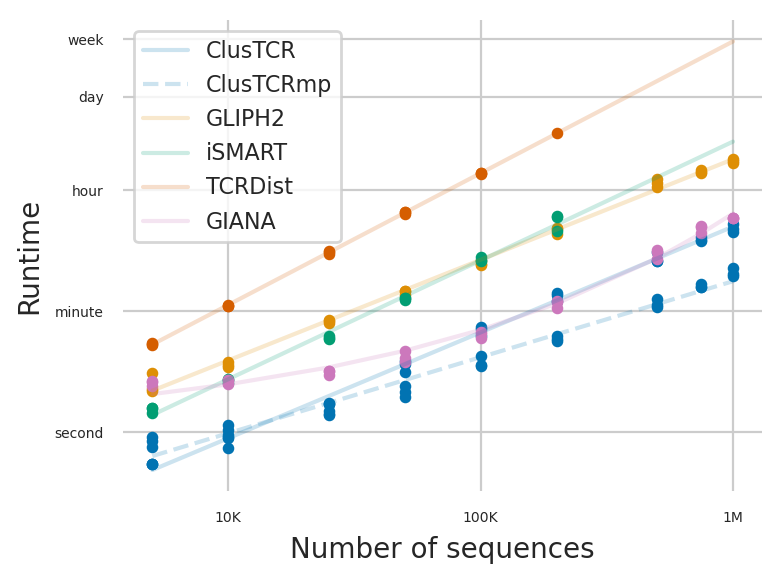

In [249]:
import seaborn as sns

speed = pd.read_csv("./data/method_comparison_speed.tsv", sep="\t")

ylabs = {
    "second":np.log10(1),
    "minute":np.log10(60),
    "hour":np.log10(3600),
    "day":np.log10(3600*24),
    "week":np.log10(3600*24*7)
    }

x = np.log10(speed["n_sequences"])
colors = sns.color_palette("colorblind")[:5]

with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots(figsize=(4,3), dpi=200)

    method = "ClusTCR¹"
    x_pred, y_pred = linear_fit(speed, "n_sequences", method)
    ax.scatter(x, get_y(speed,method), s=10, c=colors[0])
    ax.plot(x_pred, y_pred, label="ClusTCR", alpha=.2, c=colors[0])

    method = "ClusTCR²"
    x_pred, y_pred = linear_fit(speed, "n_sequences", method)
    ax.scatter(x, get_y(speed,method), s=10, c=colors[0])
    ax.plot(x_pred, y_pred, label="ClusTCRmp", alpha=.2, c=colors[0], ls="--")

    method = "GLIPH2"
    x_pred, y_pred = linear_fit(speed, "n_sequences", method)
    ax.scatter(x, get_y(speed,method), s=10, c=colors[1])
    ax.plot(x_pred, y_pred, label=method, alpha=.2, c=colors[1])

    method = "iSMART"
    x_pred, y_pred = linear_fit(speed, "n_sequences", method)
    ax.scatter(x, get_y(speed,method), s=10, c=colors[2])
    ax.plot(x_pred, y_pred, label=method, alpha=.2, c=colors[2])

    method = "TCRDist*"
    x_pred, y_pred = linear_fit(speed, "n_sequences", method)
    ax.scatter(x, get_y(speed,method), s=10, c=colors[3])
    ax.plot(x_pred, y_pred, label="TCRDist", alpha=.2, c=colors[3])

    method = "GIANA"
    x_pred, y_pred = logarithmic_fit(speed, "n_sequences", method)
    ax.scatter(x, get_y(speed,method), s=10, c=colors[4])
    ax.plot(x_pred, y_pred, label=method, alpha=.2, c=colors[4])

    ax.set_xlabel("Number of sequences")
    ax.set_ylabel("Runtime")

    ax.set_yticks(list(ylabs.values()))
    ax.set_yticklabels(list(ylabs.keys()), fontsize=5)

    ax.set_xticks([4,5,6])
    ax.set_xticklabels(["10K", "100K", "1M"], fontsize=5)

    ax.legend(fontsize=8)
    
    sns.despine(left=True, bottom=True)
    
    fig.tight_layout()

In [251]:
fig.savefig("/home/sebastiaan/PhD/Repositories/clustcr_demo/fig/benchmark.png", format="png")

/home/sebastiaan/miniconda3/envs/clustcr/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


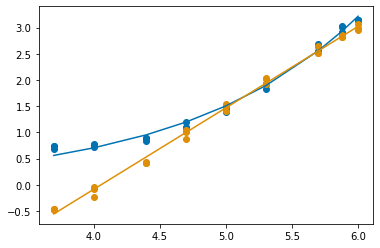

In [248]:
plt.scatter(np.log10(speed.n_sequences), np.log10(speed.GIANA))
plt.scatter(np.log10(speed.n_sequences), np.log10(speed["ClusTCR¹"]))

# xgi, ygi = linear_fit(speed, "n_sequences", "GIANA")
xcl, ycl = linear_fit(speed, "n_sequences", "ClusTCR¹")

xgi, ygi = logarithmic_fit(speed, "n_sequences", "GIANA")

plt.plot(xgi, ygi)
plt.plot(xcl, ycl)

In [244]:
def logfunc(x, a, b, c):
    return a * np.exp(-b * (x + c))

popt, _ = curve_fit(f = logfunc, 
                    xdata = np.log10(speed.n_sequences), 
                    ydata = np.log10(speed.GIANA))

In [245]:
popt

array([ 0.20362813, -0.75993918, -2.36815716])